In [2]:
#packages
import numpy as np
import tensorflow as tf
import helpers

In [3]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [4]:
# version of Tensorflow
tf.__version__

'1.11.0'

In [25]:
PAD= 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units*2

In [6]:
#3 placeholders - gateways
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [7]:
#embeddings
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [8]:
#define encoder
from tensorflow.python.ops.rnn_cell  import LSTMCell, LSTMStateTuple

## Neual Network Architecture 

Here we are building a seq2seq Recurrent Neural Network (RNN)) using a bidirectional $encoder$
- Simple LSTM Cells are used
- Is also possible to use Gated Recurrent Units (GRU's)


![title](structure.png)

In [ ]:
encoder_cell = LSTMCell(encoder_hidden_units) #20 cells

In [10]:
## Bidirectional RNN Setup
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell, 
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

#When using a standard RNN to make predictions we are only taking the “past” into account. 
#For certain tasks this makes sense (e.g. predicting the next word), but for some tasks 

In [11]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [12]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [13]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_4:0' shape=(?, 20) dtype=float32>)

In [14]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_4:0' shape=(?, 20) dtype=float32>)

## Concatenates (tf.concat)

Here we keep both $output$ and $state$. We will use the state for attention, which is applied later on. It is possible to drop the states if attention isnt applied and will be more computationally efficient. 

In [15]:
#biderectional step
#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)


## Decoder

The decoder contains a simple LSTM cell with attention (soft) - manually defining them. 

Next we need to decide how far to run decoder. There are several options for stopping criteria:

- Stop after specified number of unrolling steps
- Stop after model produced

Here we are doing a toy copy task, so how about we unroll decoder for len(encoder_input)+2, to allow model some room to make mistakes over 2 additional steps:

In [22]:
#define the decoder 
decoder_cell = LSTMCell(decoder_hidden_units)

#we could print this, won't need
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

decoder_lengths = encoder_inputs_length + 3
# +2 additional steps, +1 leading <EOS> token for decoder inputs

## Output Projection

In [23]:
#manually specifying since we are going to implement attention details for the decoder in a sec
#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [26]:
#create padded inputs for the decoder from the word embeddings

#were telling the program to test a condition, and trigger an error if the condition is false.
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

#retrieves rows of the params tensor. The behavior is similar to using indexing with arrays in numpy
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

## Soft Attention

In [27]:
#we define and return these values, no operations occur here
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    #end of sentence
    initial_input = eos_step_embedded
    #last time steps cell state
    initial_cell_state = encoder_final_state
    #none
    initial_cell_output = None
    #none
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [28]:
#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    
    
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [30]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [31]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

## Reshaping of output Tensors

In [34]:
#to convert output to human readable prediction
#we will reshape output tensor

#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)

## Optimizers

Here we are using a cross-entropy loss function and 'Adam' optimizer algorithm in order to ensure convergence. 

In [36]:
#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)

In [37]:
sess.run(tf.global_variables_initializer())

## Training 

In [38]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[8, 4, 5]
[3, 4, 9, 7, 2]
[9, 9, 3, 9]
[5, 3, 5, 3, 4]
[2, 4, 9]
[7, 2, 6]
[4, 4, 2, 2]
[2, 4, 3, 9, 9, 5, 2]
[6, 4, 9, 3, 5, 6, 9]
[9, 4, 4]


In [39]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [41]:
loss_track = []

In [44]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 0.13415655493736267
  sample 1:
    input     > [4 7 9 8 2 6 0 0]
    predicted > [4 7 9 8 2 6 1 0 0 0 0]
  sample 2:
    input     > [3 4 3 0 0 0 0 0]
    predicted > [3 4 3 1 0 0 0 0 0 0 0]
  sample 3:
    input     > [7 9 8 7 8 0 0 0]
    predicted > [7 9 8 7 8 1 0 0 0 0 0]

batch 1000
  minibatch loss: 0.10308825969696045
  sample 1:
    input     > [6 8 9 0 0 0 0 0]
    predicted > [6 8 9 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [3 7 8 3 7 0 0 0]
    predicted > [3 7 8 3 7 1 0 0 0 0 0]
  sample 3:
    input     > [5 2 6 2 5 6 3 6]
    predicted > [5 2 6 6 5 6 3 6 1 0 0]

batch 2000
  minibatch loss: 0.05600270628929138
  sample 1:
    input     > [8 2 7 0 0 0 0 0]
    predicted > [8 2 7 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [6 7 6 8 6 2 8 0]
    predicted > [6 7 6 8 6 2 8 1 0 0 0]
  sample 3:
    input     > [6 6 8 4 2 8 6 0]
    predicted > [6 6 8 4 2 8 6 1 0 0 0]

batch 3000
  minibatch loss: 0.04189540445804596
  sample 1:
    input     > [7

loss 0.1446 after 300100 examples (batch_size=100)


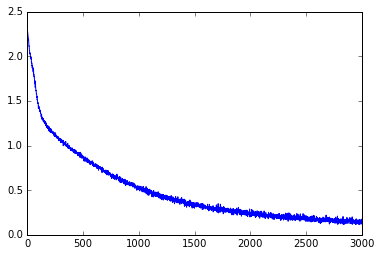

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))